In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tables
import simweights

In [3]:
file_path_22612 = "/data/user/tvaneede/GlobalFit/reco_processing/hdf/output/v2_allvar/NuE_22613.h5"
hdf_22612 = pd.HDFStore(file_path_22612,'r')

In [4]:
# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
livetime_s = 12*365*24*60*60 # 12 yr
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [5]:
weighter_22612 = simweights.NuGenWeighter( hdf_22612,nfiles=2000)
weights_22612 = weighter_22612.get_weights(AstroFluxModel) * livetime_s 

In [13]:
# from neha
def error_cal(bin_edges,weights,data):
    errors = []
    bin_centers = []
    
    for bin_index in range(len(bin_edges) - 1):

        # find which data points are inside this bin
        bin_left = bin_edges[bin_index]
        bin_right = bin_edges[bin_index + 1]
        in_bin = np.logical_and(bin_left < data, data <= bin_right)
        

        # filter the weights to only those inside the bin
        weights_in_bin = weights[in_bin]

        # compute the error however you want
        error = np.sqrt(np.sum(weights_in_bin ** 2))
        errors.append(error)

        # save the center of the bins to plot the errorbar in the right place
        bin_center = (bin_right + bin_left) / 2
        bin_centers.append(bin_center)

    errors=np.asarray(errors)
    bin_centers=np.asarray(bin_centers)
    return errors, bin_centers


/tmp/ipykernel_39358/3960935264.py:16: RuntimeWarning: invalid value encountered in divide
  rel_error_poisson = np.sqrt(hist_unweight)/hist_unweight


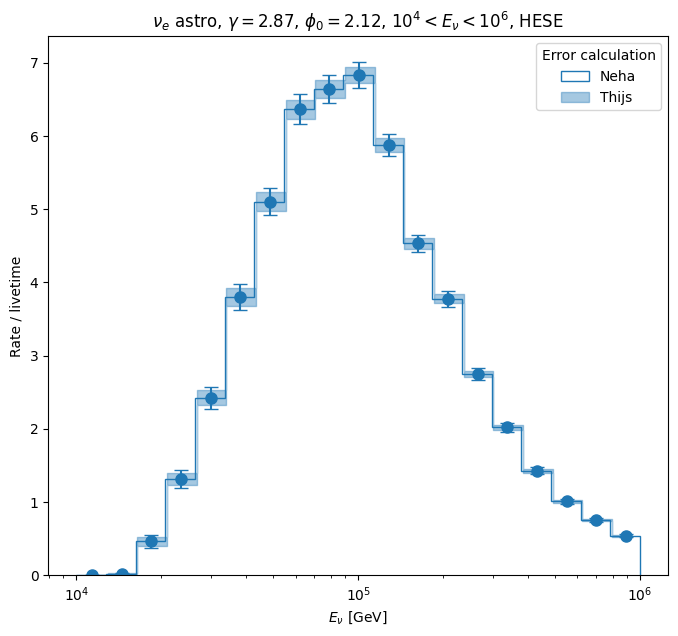

In [30]:
energy_nu = weighter_22612.get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")

# binning
bins = np.geomspace(1e4, 1e6, 20)


fig, ax = plt.subplots(1, 1,figsize =(8,7))
hist, bin_edges = np.histogram(energy_nu, bins=bins, weights=weights_22612)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# neha error calc
error_neha, _ = error_cal(bin_edges=bin_edges,weights=weights_22612, data=energy_nu)

# thijs error calc
hist_unweight, _ = np.histogram(energy_nu, bins=bins)
rel_error_poisson = np.sqrt(hist_unweight)/hist_unweight
rel_error_poisson = np.zeros_like(hist, dtype=float) # Relative Poisson error
mask = hist_unweight > 0
rel_error_poisson[mask] = np.sqrt(hist_unweight[mask]) / hist_unweight[mask]
abs_error = hist * rel_error_poisson # Absolute error on weighted histogram

ax.hist(energy_nu, weights=weights_22612, 
        bins=bins, histtype="step", label="Neha", color="C0")

# Plot the error band
ax.fill_between(bin_centers, hist - abs_error, hist + abs_error,
                step="mid", alpha=0.4, color="C0", label="Thijs")

ax.errorbar(x=bin_centers, y=hist,yerr=error_neha, color="C0",fmt='o', markersize=8,capsize=5)

ax.set_title(r"$\nu_e$ astro, $\gamma = 2.87$, $\phi_0=2.12$, $10^4 < E_\nu < 10^6$, HESE")
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_ylabel("Rate / livetime")
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.legend(title="Error calculation")


In [28]:
print(abs_error)
print(error_neha)


[0.         0.01155677 0.0588505  0.08429851 0.10279345 0.12022174
 0.12607779 0.13089468 0.12188931 0.11186876 0.09301658 0.07288494
 0.06101764 0.04564359 0.03533235 0.02657259 0.01976084 0.01523945
 0.01159108]
[0.         0.01158853 0.08462432 0.12097775 0.14802847 0.18151011
 0.18771669 0.20354222 0.19342368 0.18047279 0.14951608 0.12060959
 0.10568397 0.07657618 0.06131638 0.0479038  0.03557428 0.02771649
 0.02213148]


/tmp/ipykernel_39358/3095011994.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


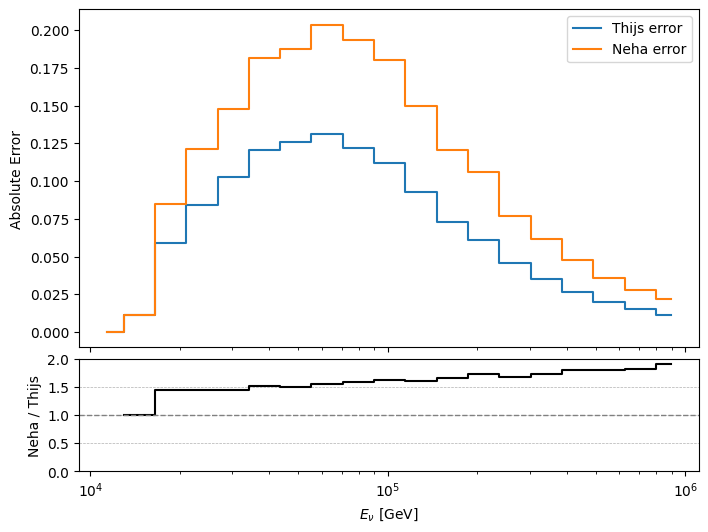

In [31]:
# ratio errors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming: error_neha and abs_error_thijs are already computed and aligned with bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Ratio of errors
with np.errstate(divide='ignore', invalid='ignore'):
    error_ratio = np.ones_like(error_neha)
    valid = abs_error > 0
    error_ratio[valid] = error_neha[valid] / abs_error[valid]
    error_ratio[~valid] = np.nan  # NaNs where division not possible

# --- PLOTTING ---
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

# Upper panel: error comparison
ax0 = plt.subplot(gs[0])
ax0.step(bin_centers, abs_error, where='mid', label='Thijs error', color='C0')
ax0.step(bin_centers, error_neha, where='mid', label='Neha error', color='C1')
ax0.set_xscale('log')
ax0.set_ylabel('Absolute Error')
ax0.legend()
ax0.tick_params(labelbottom=False)

# Lower panel: ratio
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.step(bin_centers, error_ratio, where='mid', color='black')
ax1.axhline(1, linestyle='--', color='gray', linewidth=1)
ax1.set_xscale('log')
ax1.set_xlabel(r'$E_\nu$ [GeV]')
ax1.set_ylabel('Neha / Thijs')
ax1.set_ylim(0, 2)
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()




I underestimate the error, and I don't take into account the variation of weights in a bin. Neha's way should be used.